In [ ]:
%matplotlib inline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

In [ ]:
custom_style = {
    'figure.figsize': (8, 6),
    'font.family':'sans-serif',
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

In [ ]:
def soma():
    x=float(input("Número:"))
    y=float(input("Número:"))
    print(x+y)
    return x

soma()

/home/rodrigo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_13221/2143345250.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = cluster_labels                                           # Add cluster labels to the original data frame
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1

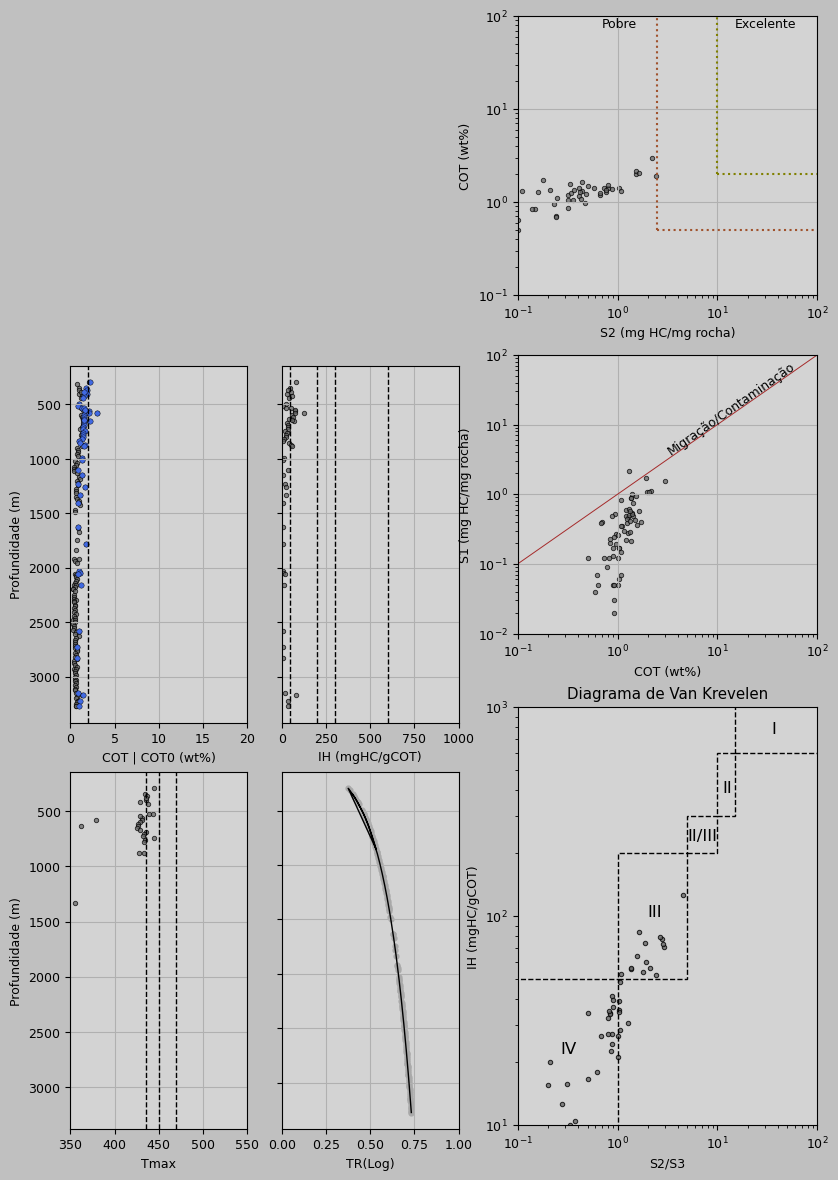

In [22]:
def maturation():
    poço=str(input("Informar nome do Poço: "))
    lamdagua=float(input("Informar lâmina d'água (m):"))
    # Importação de dados

    df1 = pd.read_csv("Poços_Marinho/"+poço+".csv")
    df=df1[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO"]]

    # Agrupamento para Cálculo de COTa

    num_clusters = 3                                                         # Number of clusters you want to create
    X = df[["COT","S1","S2","S3","Tmax"]].fillna(0)                          # Extract the columns for clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)                # Apply k-means clustering
    kmeans.fit(X)                                                            # Use X_scaled if you scaled the data, otherwise use X
    cluster_labels = kmeans.labels_                                          # Get cluster assignments and centroids
    centroids = kmeans.cluster_centers_    
    df['Cluster'] = cluster_labels                                           # Add cluster labels to the original data frame
    df1=df.dropna(subset=["COT","S2"])                                       # Extract data from DataFrame
    x_data = df1['S2'].values.reshape(-1, 1)  
    y_data = df1['COT'].values
    model = LinearRegression()                                               # Fit linear regression model
    model.fit(x_data, y_data)
    slope = model.coef_[0]                                                   # Get the slope (coefficient) and y-intercept of the trend line
    intercept = model.intercept_           
    
    # Regressão linear para cálculo de COTa

    models = {}
    for cluster_id in range(num_clusters):
        cluster_data = df[df['Cluster'] == cluster_id]
        x_values = cluster_data[["S2"]].fillna(value=0)
        y_values = cluster_data["COT"]
        model = LinearRegression()
        model.fit(x_values, y_values)
        models[cluster_id] = model
    dic={}                                                                    # Print the linear regression equations for each cluster
    for cluster_id, model in models.items():
        slope = model.coef_[0]
        intercept = model.intercept_
        dic[cluster_id]=intercept
    
    # Cálculo de COTa

    COTativo=[]
    for idx,row in df.iterrows():
        #print(row["Cluster"])
        Cluster=row["Cluster"]
        COT=row["COT"]
        intercept=dic[Cluster]
        COTa= COT- intercept
        COTativo.append(COTa)
    df["COTa"]=COTativo
    df
    COT_cor=[]
    for i in df["COTa"]:
        if i >= 0:
            COT_cor.append(i)
        else:
            COT_cor.append(0)
    df["COTa"]=COT_cor

    # Cálculo de IHa

    IHa = (100*df["S2"]/df["COTa"])
    IHa_cor=[]
    for i in IHa:
        if i<0:
            IHa_cor.append(0)
        elif i>999:
            IHa_cor.append(999)
        else:
            IHa_cor.append(i) # Eliminar valores
    df["IH0a"]= IHa_cor
    
    # Taxa de Transformação sem Ro (IH)

    df["Taxa de Transformação (IH)"] = ((df["IH0a"]-df["IH"])/df["IH0a"])
    TrIH=[]
    for i in df["Taxa de Transformação (IH)"]:
        if i<0:
            TrIH.append(0)
        elif i>1:
            TrIH.append=1
        else:
            TrIH.append(i)
    df["Taxa de Transformação (IH)"]=TrIH

    # Cálculo de Ro pela Tmax

    df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
    Roc_cor=[]
    for i in df["Ro (calculada)"]:
        if i<0:
            Roc_cor.append(0)
        else:
            Roc_cor.append(i)
    df["Ro (calculada)"]=Roc_cor

    # Classificação do querogênio (IH)

    K = []
    for i in df["IH"]:
        if i > 600:
            a="I"
        elif i > 300 and i <=600:
            a="II"
        elif i > 200 and i <= 300:
            a="II/III"
        elif i > 50 and i <= 200:
            a="III"
        elif i>0 and i<=50:
            a="IV"
        else:
            a=""
        K.append(a)
    querogênio=pd.DataFrame(K)
    df["Querogênio"]=querogênio

    # Lógica Fuzzy (em desenvolvimento)

    T1 = []
    T2 = []
    T3 = []
    T4 = []
    for i in df["IH"]: 
        if i >= 800:
            end = ((i - 999)/(800 - 999))*100
            T1.append(100) 
            T2.append(0)
            T3.append(0)
            T4.append(0) 
        elif i >= 425 and i <=800:
            end = ((i - 800)/(425 - 800))*100
            T1.append(100-end) 
            T2.append(end)
            T3.append(0)
            T4.append(0) 
        elif i >= 150 and i < 425:
            end = ((i - 425)/(150 - 425))*100
            T1.append(0) 
            T2.append(100-end)
            T3.append(end)
            T4.append(0) 
        elif i >=25 and i < 150:
            end = ((i - 150)/(25 - 150))*100
            T1.append(0) 
            T2.append(0)
            T3.append(100-end)
            T4.append(end) 
        elif i>=0 and i < 25:
            T1.append(0) 
            T2.append(0)
            T3.append(0)
            T4.append(100) 
        else:
            T1.append(0) 
            T2.append(0)
            T3.append(0)
            T4.append(0) 
    df["% Tipo I"]=T1
    df["% Tipo II"]=T2
    df["% Tipo III"]=T3
    df["% Tipo IV"]=T4
    df.to_csv("Planilha.csv")

    # Decisão sobre tipo de querogênio

    TI=df["% Tipo I"].dropna().values.sum()
    TII=df["% Tipo II"].dropna().values.sum()
    TIII=df["% Tipo III"].dropna().values.sum()
    TIV=df["% Tipo IV"].dropna().values.sum()
    Ro = df["Ro (calculada)"].mean()
    Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
    Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
    Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)
        
    if TI > TII and TI > TIII and TI > TIV:
        TRo=Eq_I
    elif TII > TI and TII > TIII and TII > TIV:
        TRo=Eq_II
    elif TIII > TI and TIII > TII and TIII > TIV:
        TRo=Eq_III
    else:
        TRo=0

    if i > 1:
        TRo = 1
    elif TRo < 0:
        TRo = 0
    else:
        TRo = TRo

    L=lamdagua
    MRo = TRo                                                                              #df["Taxa de Transformação (Ro)"].mean()
    MIH = df["Taxa de Transformação (IH)"].median()
    MinIH = df["Taxa de Transformação (IH)"].min()
    MedIH = df["Taxa de Transformação (IH)"].mean()    
    x1 = [L, df["Profundidade"].max()]                                                     # Cálculo para valores de Ro calculada
    y1 = [0, MRo]
    log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
    a1 = log_fit[0][0]
    b1 = log_fit[0][1]
    df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])                                 #Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
    x2 = [L, df["Profundidade"].max()]                                                     # Cálculo para valores de IH (mediana)
    y2 = [0, MIH]
    log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
    a2 = log_fit[0][0]
    b2 = log_fit[0][1]
    df['Tr_IH_Log (mdn)'] = a2 + b2 * np.log(df["Profundidade"])    
    x2 = [L, df["Profundidade"].max()]                                                     # Cálculo para valores de IH (mínimo)
    y2 = [0, MinIH]
    log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
    a2 = log_fit[0][0]
    b2 = log_fit[0][1]
    df['Tr_IH_Log (min)'] = a2 + b2 * np.log(df["Profundidade"])
    x2 = [L, df["Profundidade"].max()]                                                     # Cálculo para valores de IH (média)
    y2 = [0, MedIH]
    log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
    a2 = log_fit[0][0]
    b2 = log_fit[0][1]
    df['Tr_IH_Log (med)'] = a2 + b2 * np.log(df["Profundidade"])
    
    # Decisão sobre a curva log

    mdn = df["Tr_IH_Log (mdn)"].values
    min = df["Tr_IH_Log (min)"].values
    med = df["Tr_IH_Log (med)"].values
    Ro = df["Tr_Ro_Log"].values

    sub1=np.sqrt((df["Tr_IH_Log (mdn)"]-df["Tr_Ro_Log"])**2)
    sub2=np.sqrt((df["Tr_IH_Log (min)"]-df["Tr_Ro_Log"])**2)
    sub3=np.sqrt((df["Tr_IH_Log (med)"]-df["Tr_Ro_Log"])**2)
    
    if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
        a=mdn
    elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
        a=min
    else:
        a=med

    # Cálculo de COT0, S20, IH0, OSI e S2/S3

    Tr = df["Taxa de Transformação (IH)"]
    df["S20"]=df["S2"]/(1-Tr)
    df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
    df["IH0"]=100*df["S20"]/df["COT0"]
    df["OSI"]=((df["S1"]/df["COT"])*100)
    df["S2/S3"]=df["S2"]/df["S3"]

    #================================================GRÁFICO DE OUTPUT=============================================#

    # Figura com tamanho A4

    a4_width = 8.27  # inches
    a4_height = 11.69  # inches

    fig = plt.figure(figsize=(a4_width, a4_height), layout='constrained')

    # Grid

    L1 = GridSpec(3,4, figure=fig, width_ratios=[1, 1,1,2], height_ratios=[1,1, 1.5])
    L2 = GridSpec(3,4, figure=fig)

    # Posição dos gráficos 

    ax1=fig.add_subplot(L2[1,0]) #==== COT ======#
    ax2=fig.add_subplot(L2[1,1]) #==== IH ======#
    ax3=fig.add_subplot(L2[2,0]) #==== Tmax ======#
    ax4=fig.add_subplot(L2[2,1]) #==== Tr (log) ======#
    ax5=fig.add_subplot(L1[2,-1]) #=== Van krevelen ===#
    ax6=fig.add_subplot(L1[0,-1]) #===COT x S2 ====#
    #ax7=fig.add_subplot(spec[2,3]) #=== OSI ===#
    ax8=fig.add_subplot(L1[1,-1]) #== OSI (S1 x COT)==#
    plt.style.use(custom_style)

    #==== COT ======#

    ax1.scatter(df["COT"], df["Profundidade"], color="dimgray",s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
    ax1.scatter(df["COT0"], df["Profundidade"],s=15,c="royalblue", edgecolor="black", linewidth=0.3)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_xlim(0.0, 20.0)
    ax1.axvline(2, color="black", linewidth=1, linestyle="--")
    ax1.set_xlabel("COT | COT0 (wt%)")
    ax1.set_ylabel("Profundidade (m)")

    #==== IH ======#

    ax2.scatter(df["IH"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
    ax2.axvline(600, color="black", linewidth=1, linestyle="--")
    ax2.axvline(300, color="black", linewidth=1, linestyle="--")
    ax2.axvline(200, color="black", linewidth=1, linestyle="--")
    ax2.axvline(50, color="black", linewidth=1, linestyle="--")
    ax2.set_xlabel("IH (mgHC/gCOT)")
    ax2.set_xlim(0.0, 1000.0)
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticklabels([])
    ax2.set_ylabel("")

    #==== Tmax ======#

    ax3.scatter(df["Tmax"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
    ax3.set_ylim(ax3.get_ylim()[::-1])
    ax3.axvline(435, color="black", linewidth=1, linestyle="--")
    ax3.axvline(450, color="black", linewidth=1, linestyle="--")
    ax3.axvline(470, color="black", linewidth=1, linestyle="--")
    ax3.set_xlabel("Tmax")
    ax3.set_ylabel("Profundidade (m)")
    ax3.set_xlim(350,550)

    #==== Tr (log) ======#
    y = df["Profundidade"].values

    if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
        a=mdn
    elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
        a=min
    else:
        a=med

    ax4.plot(a, y, color='black', linewidth=1)
    ax4.scatter(a, y, color='darkgray', s=12)
    ax4.set_ylim(ax4.get_ylim()[::-1])
    ax4.set_xlabel("TR(Log)")
    ax4.set_ylabel("")
    ax4.set_yticklabels([])
    ax4.set_xlim(0,1)

    #====== Van krevelen ======#

    ax5.scatter(df["S2/S3"], df["IH"], color="dimgray", edgecolor="black", s=10, linewidth=0.75, alpha=0.8)
    ax5.add_patch(patches.Rectangle((15,600),400,500, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo 1
    ax5.add_patch(patches.Rectangle((10,300),5,300, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo II
    ax5.add_patch(patches.Rectangle((5,200),5,100, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo II/III
    ax5.add_patch(patches.Rectangle((1,50),4,150, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo III
    ax5.add_patch(patches.Rectangle((0,0),1,50, linewidth=1, edgecolor='black', facecolor='none', linestyle="--"))  # Tipo IV
    ax5.text(35,750, "I", fontsize=12)
    ax5.text(11.3,390, "II", fontsize=12)
    ax5.text(5.0,230, "II/III", fontsize=12)
    ax5.text(2.0,100, "III", fontsize=12)
    ax5.text(0.27,22, "IV", fontsize=12)
    ax5.set_xscale("log")
    ax5.set_yscale("log")
    ax5.set_xlim(0.1,100)
    ax5.set_ylim(10,1000)
    ax5.set_xlabel("S2/S3")
    ax5.set_ylabel("IH (mgHC/gCOT)")
    ax5.set_title("Diagrama de Van Krevelen")
    ax5.grid(False)

    #======== COT x S2 ========#

    ax6.scatter(df["S2"], df["COT"], color="dimgray",s=10,edgecolor='black', linewidth=0.65, alpha=0.75 )
    ax6.set_xscale("log")
    ax6.set_yscale("log")
    ax6.plot([10,10],[2,100], color="olive", linestyle=":", linewidth=1.5)
    ax6.plot([10,100],[2,2], color="olive", linestyle=":", linewidth=1.5)
    ax6.plot([2.5,2.5],[0.5,100], color="sienna", linestyle=":", linewidth=1.5)
    ax6.plot([2.5,100],[0.5,0.5], color="sienna", linestyle=":", linewidth=1.5)
    ax6.text(15,75, "Excelente")
    ax6.text(0.7,75, "Pobre")
    ax6.set_xlabel("S2 (mg HC/mg rocha)")
    ax6.set_ylabel("COT (wt%)")
    ax6.set_xlim(0.1,100)
    ax6.set_ylim(0.1,100)

    #========= OSI (S1 x COT)============#

    ax8.plot([0,100],[0,100], color="brown", linestyle="-", linewidth=0.7)
    ax8.scatter(df["COT"], df["S1"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
    ax8.set_ylabel("S1 (mg HC/mg rocha)")
    ax8.set_xlabel("COT (wt%)")
    ax8.text(3.0, 3.7, "Migração/Contaminação", rotation=35)
    ax8.set_xlim(0.1,100.0)
    ax8.set_ylim(0.01,100.0)
    ax8.set_xscale("log")
    ax8.set_yscale("log")
    plt.savefig("Outputs_Figuras/"+poço+".pdf")

    #================================================PLANILHA DE OUTPUT=============================================#

    mdn1 = df["Tr_IH_Log (mdn)"]
    min1 = df["Tr_IH_Log (min)"]
    med1 = df["Tr_IH_Log (med)"]

    if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
        b=mdn
    elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
        b=min
    else:
        b=med
    df_csv=df[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO","Cluster"]]
    df_csv[["COTa","IH0a"]]=df[["COTa","IH0"]].round(2)
    df_csv["Querogênio"]=df["Querogênio"]
    df_csv["Tr_Ro_Log"]=df["Tr_Ro_Log"].round(3)
    df_csv["Tr_IH_Log"]=b.round(3) 
    df_csv[["COT0","S20","IH0"]]=df[["COT0","S20","IH0"]].round(2)
    df_csv.to_csv("Outputs_Planilhas/"+poço+".csv")
  

maturation()
    




